In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import numpy as np

df = pd.read_csv("DataFrame.csv", encoding="utf-8")

## 1.1 -  Machine Learning non supervisé : Clustering avec KMeans

L'objectif ici est d'identifier des groupes naturels de vulnérabilités en fonction de leur niveau de criticité (CVSS) et de leur probabilité d'exploitation (EPSS).
L'objectif est de détecter des profils types de menaces pour prioriser les alertes ou adapter les actions de sécurité

Variables choisies : 
- CVSS_score : indicateur de la gravité technique de la vulnérabilité
- EPSS_score : probabilité que la faille soit exploitée

Comme nous avons pu le voir lors de l'étape 5, ces deux variables sont complémentaires et permettent de regrouper les failles en fonction de leur dangerosité réelle.

Nous avons choisi l’algorithme KMeans, car :

- il est simple à implémenter
- il est adapté aux données numériques continues comme CVSS_score (gravité technique) et EPSS_score (probabilité d’exploitation)
- il permet de regrouper les vulnérabilités en catégories pertinentes sans supervision humaine



## 1.2 - Validation de notre modèle non supervisé (KMeans) : 

Afin de valider la qualité de notre modèle non supervisé KMeans, nous allons utilisé 3 indicateurs de validation internes :

- Score de silhouette : mesure dans quelle mesure chaque point est plus proche de son propre cluster que des autres. Il varie de -1 à 1. Un score proche de 1 indique un clustering bien formé

- Indice de Davies-Bouldin : mesure le rapport entre la compacité des clusters et leur séparation. Plus l’indice est bas, meilleure est la séparation entre les groupes

- Indice de Calinski-Harabasz : évalue le rapport entre la dispersion inter-clusters et la dispersion intra-clusters. Plus il est élevé, plus les clusters sont bien distincts

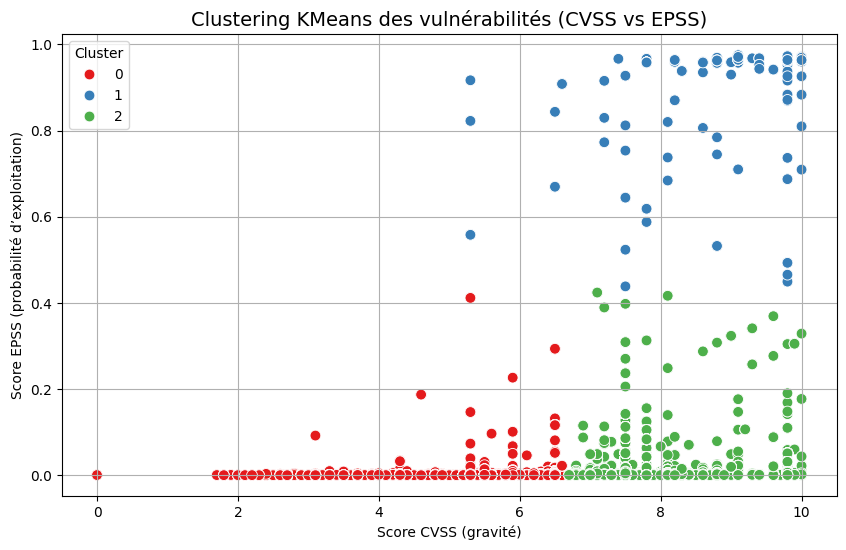

Silhouette Score : 0.6006
Calinski-Harabasz Index : 74055.47
Davies-Bouldin Index : 0.4624


In [ ]:
# Non supervisé - KMeans

df_cluster = df[["CVSS_score", "EPSS_score"]].copy() #on garde uniquement les colonnes utiles
df_cluster.dropna(inplace=True) #on retire les lignes où l'une des deux colonnes est manquante

#normalisation des données 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cluster)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
df_cluster["Cluster"] = clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="CVSS_score",
    y="EPSS_score",
    hue="Cluster",
    palette="Set1",
    data=df_cluster,
    s=60
)
plt.title("Clustering KMeans des vulnérabilités (CVSS vs EPSS)", fontsize=14)
plt.xlabel("Score CVSS (gravité)")
plt.ylabel("Score EPSS (probabilité d’exploitation)")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()




# VALIDATION DU CLUSTERING 

# 1. Silhouette Score
silhouette = silhouette_score(data_scaled, clusters)
print(f"Silhouette Score : {silhouette:.4f}")

# 2. Calinski-Harabasz Index
calinski = calinski_harabasz_score(data_scaled, clusters)
print(f"Calinski-Harabasz Index : {calinski:.2f}")

# 3. Davies-Bouldin Index (plus petit = meilleur)
davies = davies_bouldin_score(data_scaled, clusters)
print(f"Davies-Bouldin Index : {davies:.4f}")


Nous avons appliqué KMeans avec 3 clusters, ce qui a révélé trois types de vulnérabilités :

- Cluster 0 (rouge) : Ce groupe contient principalement des vulnérabilités peu critiques (CVSS bas à moyen) et très peu exploitable (EPSS très faible). Ces vulnérabilités sont donc à un faible risque et peu prioritaire

- Cluster 1 (bleu) : Ce groupe représente des vulnérabilités graves et critiques (CVSS élevés) et fortement exploitables (EPSS élevé). Il représente les vulnérabilités à traiter en priorité

- Cluster 2 (vert) : Ce groupe contient les vulnérabiltés graves et critiques mais peu exploitables en pratique (CVSS élevé mais EPSS bas). Elles nécessitent une surveillance, mais peuvent être moins urgentes si aucune menace active n’est détectée.

Pour évaluer la qualité des clusters produits par notre modèle KMeans, nous avons utilisé 3 indicateurs. 
- Score de silhouette : 

Cet indicateur mesure la cohésion interne des points dans un même cluster et la séparation entre les clusters. Le score de silhouette est compris entre -1 et 1.

Ici score obtenu est ≈ 0,6 , ce qui indique que les clusters identifiés sont plutôt bien formés, avec peu de chevauchements et que le regroupement fait sens sur les deux dimensions considérées (CVSS + EPSS)


- Indice de Calinski-Harabasz : 

Cet indicateur mesure le rapport entre la dispersion entre les clusters (inter-classes) et la dispersion au sein des clusters (intra-classes). Plus l'indice est élevé, meilleure
est la séparation entre les clusters.
Ici, l'indice obtenu est 74055.47, ce qui est un très bon résultat. Cela confirme que les groupes formés sont bien distincts les uns des autres, avec peu de recouvrement.

- Indice de Davies-Bouldin : 

Cet indice repose sur le rapport entre la distance entre les centres de clusters et la dispersion moyenne à l’intérieur de chaque cluster.

Contrairement à l’indice précédent, plus cet indice est faible, meilleur est le clustering.
Ici, l’indice obtenu est 0.4624, ce qui est considérablement bas et donc très satisfaisant.
Cela suggère que les clusters sont à la fois compacts et bien séparés, ce qui valide la pertinence du modèle.

Ainsi : 

Les 3 métriques utilisées indique que notre modèle KMeans à 3 clusters fournit un regroupement de qualité sur les données CVSS (gravité) et EPSS (probabilité d’exploitation).
Les clusters sont cohérents, distincts, et interprétables, ce qui en fait un outil pertinent pour détecter des profils types de vulnérabilités ou prioriser des alertes de cybersécurité.

Classification supervisée avec RandomForestClassifier

Objectif : Prédire le niveau de gravité (Base_Severity) d’une vulnérabilité en se basant uniquement sur des variables disponibles dès l’annonce (CVSS + EPSS).

Choix du modèle :
- Random Forest : robuste aux outliers, efficace sans gros paramétrage, capable d’estimer l’importance des variables.
- On encode la variable cible (Base_Severity) et on fait un split train/test (70% / 30%).

Validation :
- Rapport de classification (précision, rappel, F1-score) pour chaque classe.
- Matrice de confusion pour évaluer les erreurs du modèle.

Limite :
- La gravité "Base_Severity" est fortement liée à CVSS, donc le modèle risque d’apprendre une redondance.
- D'autres variables qualitatives (CWE, éditeur) pourraient être intégrées pour augmenter la richesse.